In [2]:
# ========================== Libraries ===========================
# essentials
import sys, os, time
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta

# data format related
import csv
from netCDF4 import Dataset as NetCDFFile

# statistics
import scipy.linalg as la
from scipy.interpolate import griddata
from scipy import stats
import scipy.interpolate as scinterp
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest, resample_gauss

# ploting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib import ticker, cm
from matplotlib.offsetbox import AnchoredText 
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy as cart 
import imageio



In [3]:
# ========================== Function definitions ===========================
def savefig(path, name, dpi):
    '''
    Function that saves a figure to path_and_name.
    path : path to which the figure must be saved (string)
    name : the name of the figure.
    '''
    fig.tight_layout(pad=2.5)
    path_and_name = path + name
    print('Saving of {}'.format(path_and_name))
    try:
        os.mkdir(path)
    except FileExistsError: 
            pass
    plt.savefig(path_and_name, dpi = dpi)
    return



In [136]:
# ============== Open and read netCDF files ===============
path = 'student-storages/GROUP5/Megan/meganmalpas/10min MOSAiC met data/metcity10min_met_combined_wind.nc'

metcity_wind_xr = xr.open_dataset("/home/jovyan/" + path)

path_inp = 'student-storages/GROUP5/Megan/mosaic_data.nc'

inp_conc_xr = xr.open_dataset("/home/jovyan/" + path_inp)


<xarray.Dataset> Size: 622kB
Dimensions:           (time: 38880)
Coordinates:
  * time              (time) datetime64[ns] 311kB 2019-10-15 ... 2020-09-18T2...
Data variables:
    wspd_vec_mean_2m  (time) float64 311kB ...

In [104]:
# create an array of the INP measurements dates
dates_inp = []
for i in range(0, len(inp_conc_xr.index)):
    dates_inp.append(datetime.strptime(inp_conc_xr.index[i].item(), 'T_%Y%m%d'))
dates_inp = np.asarray(dates_inp)

In [160]:
# interpolate the metdata on the inp dates
metcity_wind_interp = metcity_wind_xr.interp(time=dates_inp)


In [161]:
# merge the two datasets
merged_data = xr.merge([metcity_wind_interp, inp_conc_xr])
merged_data

<xarray.Dataset> Size: 12kB
Dimensions:           (time: 100, index: 100)
Coordinates:
  * time              (time) datetime64[ns] 800B 2019-10-23 ... 2020-10-01
  * index             (index) <U10 4kB 'T_20191023' ... 'T_20201001'
Data variables:
    wspd_vec_mean_2m  (time) float64 800B nan 2.616 6.006 3.276 ... nan nan nan
    thirty            (index) float64 800B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    twentyfive        (index) float64 800B 0.1743 0.1072 0.1029 ... 0.03553 0.0
    twenty            (index) float64 800B 0.006315 0.01092 ... 0.003668 0.0
    fifteen           (index) float64 800B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ten               (index) float64 800B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    five              (index) float64 800B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    zero              (index) float64 800B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Date              (index) datetime64[ns] 800B 2019-10-23 ... 2020-10-01

In [133]:
# Variable selections
sdata = merged_data[['wspd_vec_mean_2m','twentyfive','twenty','fifteen']].to_dataarray()[:,:,0]
#varnames = ['Wind speed','INP30','INP25','INP20','INP15','INP10','INP5','INP0']
varnames = ['Wind speed','INP25','INP20','INP15']

AttributeError: 'DataArray' object has no attribute 'drop_coords'

Text(0.5, 1.0, 'Normalized data')

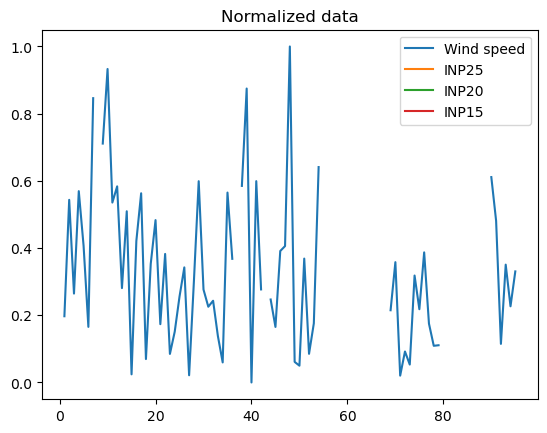

In [117]:
# ======= Normalizing the variables =========
# by min and max (0-1 range)
data_normalized = []
for i in range(0,sdata.shape[0]):    # loop over the variables
    data_min = np.min(sdata[i])
    data_max = np.max(sdata[i])
    data_normalized.append((sdata[i] - data_min)/(data_max - data_min))
data_norm = np.asarray(data_normalized)   # switch back to numpy array
# plot the normalized dataset
for i in range(0,data_norm.shape[0]):
    plt.plot(data_norm[i], label = varnames[i])
    plt.legend()
plt.title('Normalized data')


In [100]:
def PCA(data):
    '''
    Standard PCA analysis.
    data : the studied data as numpy array
    '''
    cov_matrix = np.cov(data, rowvar=False)
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # Sorting them by decreasing order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    total_var = np.sum(eigenvalues)
    vp1 = eigenvalues[0]/eigenvalues.sum().real
    vp2 = eigenvalues[1]/eigenvalues.sum().real
    vp3 = eigenvalues[2]/eigenvalues.sum().real
    pc1 = (eigenvectors[:,0]-eigenvectors[:,0].mean())/eigenvectors[:,0].std()
    pc2 = (eigenvectors[:,1]-eigenvectors[:,1].mean())/eigenvectors[:,1].std()
    pc3 = (eigenvectors[:,2]-eigenvectors[:,2].mean())/eigenvectors[:,2].std()
    # Projecting the data on the eigenvectors space to get the PCs
    pc = np.dot(data, eigenvectors)

    # -------- Figure ---------
    fig = plt.figure(figsize = (8,8))
    fig.suptitle('PCA analysis', fontsize = 16)
    gs = GridSpec(14,14)
    ax = fig.add_subplot(gs[:5,:])
    ax.plot(eigenvalues[0:10].real/eigenvalues.real.sum(), c = 'darkslategrey')
    ax.scatter(np.arange(0,10), eigenvalues[0:10].real/eigenvalues.real.sum(), c = 'teal')
    ax.set_ylabel('Eigen values (normalised)')
    ax.grid()
    ax.set_title('mode 1: {}% ; mode 2: {}% ; mode 3: {}%'.format(round(vp1*100,1), round(vp2*100, 1), round(vp3*100,1)))
    # -------------------------------
    ax2 = fig.add_subplot(gs[6:8,:])
    ax2.plot(pc1, c = 'teal', label = 'PC1')
    ax3 = fig.add_subplot(gs[9:11,:])
    ax3.plot(pc2, c = 'cyan', label = 'PC2')
    ax4 = fig.add_subplot(gs[12:14,:])
    ax4.plot(pc3, c = 'blue', label = 'PC3')
    ax2.set_ylabel('')
    ax4.set_xlabel('Time')
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax2.set_title("Principal components")
    ax2.legend()
    ax3.legend()
    ax4.legend()
    return pc1,pc2,pc3, cov_matrix
